## 获取数据

In [2]:
# 此处导入显示报错是因为keras为动态加载库，不影响使用
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from tensorflow.keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()
# train_targets为房价的中位数

In [3]:
train_data[0]

array([  1.23247,   0.     ,   8.14   ,   0.     ,   0.538  ,   6.142  ,
        91.7    ,   3.9769 ,   4.     , 307.     ,  21.     , 396.9    ,
        18.72   ])

## 数据范围过大，会影响网络训练，故标准化
## 即对于输入数据的每个特征（输入数据矩阵中的列），减去特征平均值，再除以标准差，这样得到的特征平均值为 0，标准差为 1

In [4]:
mean = train_data.mean(axis=0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
# 对test_data进行处理时，不能用它本身，而要用训练数据的
test_data -= mean
test_data /= std
train_data[0]

array([-0.27224633, -0.48361547, -0.43576161, -0.25683275, -0.1652266 ,
       -0.1764426 ,  0.81306188,  0.1166983 , -0.62624905, -0.59517003,
        1.14850044,  0.44807713,  0.8252202 ])

## 构建网络

In [5]:
from tensorflow.keras import models, layers


def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu',
                           input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## 由于数据较少，使用K折交叉验证

In [6]:
import numpy as np

k = 4  # 4折交叉验证
num_val_samples = len(train_data) // k
num_epochs = 100
all_scores = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)

    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)

    model = build_model()
    # verbose 静默模式:1/0
    model.fit(partial_train_data, partial_train_targets,
              epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

processing fold # 0


2022-04-23 22:37:18.823477: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2022-04-23 22:37:18.925009: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:03:00.0 name: NVIDIA TITAN Xp computeCapability: 6.1
coreClock: 1.582GHz coreCount: 30 deviceMemorySize: 11.91GiB deviceMemoryBandwidth: 510.07GiB/s
2022-04-23 22:37:18.925068: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2022-04-23 22:37:18.929110: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2022-04-23 22:37:18.932625: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcufft.so.10
2022-04-23 22:37:18.933155: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcurand.so.10


processing fold # 1
processing fold # 2
processing fold # 3


In [7]:
all_scores

[1.8981443643569946, 2.8672866821289062, 2.649174690246582, 2.5306951999664307]

In [8]:
np.mean(all_scores)

2.4863252341747284

## 尝试增加训练轮数，同时记录每次

In [9]:
num_epochs = 500
all_mae_histories = []
for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples]
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3


## 获取k折交叉验证的平均值

In [10]:
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 绘制图像

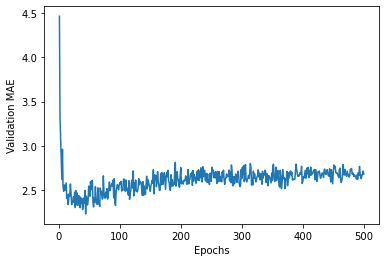

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 前几轮波动较大，筛掉
## 曲线不够光滑，将每个数据点替换为前面数据点的指数移动平均值，以得到光滑的曲线

In [12]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

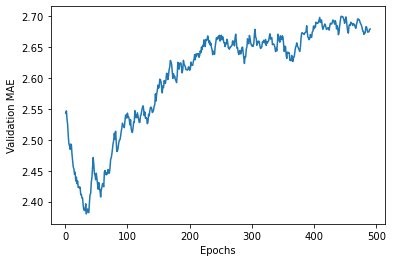

In [13]:
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 由上图看出，大约80轮后mae不再显著降低，因此可以停止训练
## 重新训练模型

In [14]:
model = build_model()
model.fit(train_data, train_targets,
          epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 17.1428 - mae: 2.5953


## 最终结果

In [15]:
test_mae_score

2.5953123569488525

---
## 小结
训练中容易造成过拟合，因此需要调整训练轮数，以及训练时的batch大小。
model.fit会返回训练过程中的history，history可以记录每次训练的结果（每个epoch都有）